NameError: name 'example_mask' is not defined

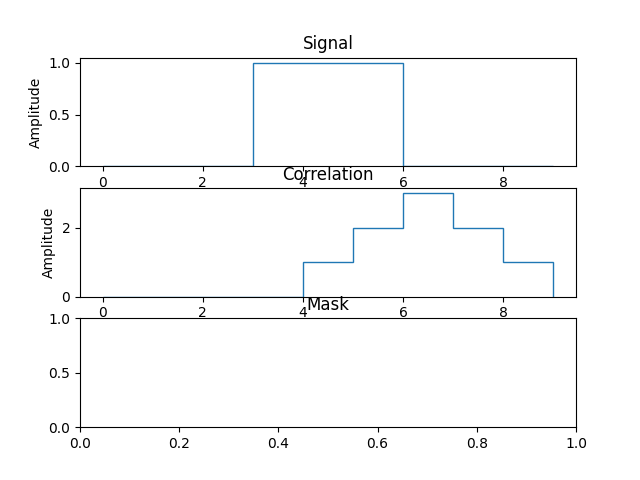

In [1]:
%matplotlib widget
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from Functions.signal_generator import generate_ADSB, digitize_signal, correlate_signals, normalize_signal
from preambules_list import Preambule, preambule_list
from Functions.utils import SAMPLE_ADSB_BYTES

# Does deconvolution
def reverse_correlation(correlation: np.ndarray, signal: np.ndarray) -> np.ndarray:
    if len(correlation) != len(signal):
        raise ValueError(f"Correlation and signal must have the same length: {len(correlation)} != {len(signal)}")
    R_f = fft(correlation)
    X_f = fft(signal, len(correlation))

    # Regularization to avoid division by zero
    eps = 1e-10
    Y_f = R_f / (X_f + eps)

    mask = np.real(ifft(Y_f))
    return mask

# Example usage
example_correlation = np.array([0, 0, 0, 0, 1, 2, 3, 2, 1])
example_signal = np.array([0, 0, 0, 1, 1, 1, 0, 0, 0])
# example_mask = reverse_correlation(example_correlation, example_signal)

plt.figure()
plt.subplot(311)
plt.title("Signal")
plt.stairs(example_signal)
plt.ylabel("Amplitude")
plt.subplot(312)
plt.title("Correlation")
plt.stairs(example_correlation)
plt.ylabel("Amplitude")
plt.subplot(313)
plt.title("Mask")
plt.stairs(example_mask)
plt.ylabel("Amplitude")
plt.xlabel("Sample, n")
plt.tight_layout()
plt.show()

In [ ]:
def cutout_signals(signal: np.ndarray, preamble: np.ndarray):

    signal_length = len(signal)
    signal = signal[:1100]
    signal = np.concatenate((signal, np.zeros(signal_length - len(signal))))

    signal_corr = correlate_signals(signal, preamble.get_coefficients())

    CUTOFF_REGION_LOW = 50
    CUTOFF_REGION_HIGH = 300
    display_signal = signal[CUTOFF_REGION_LOW:CUTOFF_REGION_HIGH]
    signal_corr = signal_corr[CUTOFF_REGION_LOW:CUTOFF_REGION_HIGH]
    return display_signal, signal_corr

#Configuration
amplitude = 1
#Generate and plot simulated ADS-B
ideal_signal, filtered_signal, noisy_signal = generate_ADSB(amplitude, SAMPLE_ADSB_BYTES, generate_bits=False)
#Digitize signal
signal, _ = digitize_signal(noisy_signal, 100E6, 10E6, 1.4, 2**10)

preamble = preambule_list[Preambule.Ideal.value]

display_signal, signal_corr  = cutout_signals(signal, preamble)
reversed_mask = reverse_correlation(signal_corr, display_signal)

plt.figure()
plt.subplot(311)
plt.title("Signal")
plt.stairs(display_signal)
plt.ylabel("Amplitude")
plt.subplot(312)
plt.title("Correlation")
plt.stairs(signal_corr)
plt.ylabel("Amplitude")
plt.subplot(313)
plt.title("Mask")
plt.stairs(reversed_mask)
plt.ylabel("Amplitude")
plt.xlabel("Sample, n")
plt.tight_layout()
plt.show()

In [ ]:
display_signal, ideal_corr  = cutout_signals(signal, preamble)
# NEveikia su vienu impulsu, reikia impulsinės charakteristikos kokios nors
target_corr = np.concatenate((np.zeros(preamble.get_expected_maximum()), np.ones(1)))
# Generate a sinc impulse
# Veikia kažkiek pamodifikavus preambulę
# target_corr = ideal_corr
# target_corr[70:100] = target_corr[69]

target_corr = np.concatenate((target_corr, np.zeros(len(display_signal) - len(target_corr))))
reversed_mask = reverse_correlation(target_corr, display_signal)

plt.figure()
plt.subplot(311)
plt.title("Signal")
plt.stairs(display_signal)
plt.ylabel("Amplitude")
plt.subplot(312)
plt.title("Target correlation")
plt.stairs(target_corr)
plt.ylabel("Amplitude")
plt.subplot(313)
plt.title("Mask")
plt.stairs(reversed_mask)
plt.ylabel("Amplitude")
plt.xlabel("Sample, n")
plt.tight_layout()
plt.show()

In [ ]:
display_signal, ideal_corr  = cutout_signals(signal, preamble)

# Sinc impulse generation
x = np.linspace(-20, 80, len(display_signal))
target_corr = np.sinc(x / np.pi)
target_corr = target_corr / np.max(np.abs(target_corr)) * np.max(np.abs(display_signal))
# target_corr = abs(target_corr)
# target_corr = normalize_signal(target_corr)
# target_corr = target_corr[len(target_corr) // 2 - preamble.get_expected_maximum():]
# target_corr = np.concatenate((target_corr, np.zeros(len(display_signal) - len(target_corr))))

reversed_mask = reverse_correlation(target_corr, display_signal)

plt.figure()
plt.subplot(311)
plt.title("Signal")
plt.stairs(display_signal)
plt.ylabel("Amplitude")
plt.subplot(312)
plt.title("Target correlation")
plt.stairs(target_corr)
plt.ylabel("Amplitude")
plt.subplot(313)
plt.title("Mask")
plt.stairs(reversed_mask)
plt.ylabel("Amplitude")
plt.xlabel("Sample, n")
plt.tight_layout()
plt.show()